# University of Utah Snow-to-Liquid Ratio Algorithm (v2019)
#### Code by Michael Wessler (Jim Steenburgh research group)
#### Based on original work by Trevor Alcott, Alcott and Steenburgh (2010)
Technique used here is a simplified version of the stepwise multiple linear regression (SMLR) method used in the paper.<br>
A curve fit is used to estimate the SMLR SLR output based on limited predictors for computational simplicity.<br>
This is the method evaluated in the 2019-2020 WPC-HMT Winter Weather Experiment. New methods in development.

## Core imports

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

## Sample Data for Unit Testing
4-dimensional data (time, level, lat, lon) provided but can use a combination of lower dimensional data (level is the only required dimension).<br>
Data may come from grib or any other format, but must conform to this structure for functions to work as they are provided.<br>
Note the QPF in this sample dataset is a 3-hourly accumulation (APCP) to conform with other 3-hourly variables.<br>
Model orography (orog) can and likely should be replaced with a higher resolution Digital Elevation Model (DEM).

In [28]:
data = xr.open_dataset('./GFS_0p25_2020011500.sample.nc').load()
data

<xarray.Dataset>
Dimensions:  (level: 13, time: 30, x: 121, y: 81)
Coordinates:
  * level    (level) int64 1000 975 950 925 900 850 800 750 700 650 600 550 500
  * time     (time) datetime64[ns] 2020-01-15 ... 2020-01-18T15:00:00
    lon      (y, x) float64 -130.0 -129.8 -129.5 -129.2 ... -100.5 -100.2 -100.0
    lat      (y, x) float64 30.0 30.0 30.0 30.0 30.0 ... 50.0 50.0 50.0 50.0
Dimensions without coordinates: x, y
Data variables:
    t        (time, level, y, x) float32 14.001434 13.801453 ... -32.608 -32.108
    tw       (time, level, y, x) float64 11.19 11.26 11.33 ... -32.65 -32.17
    gh       (time, level, y, x) float32 195.9511 195.6151 ... 5297.108
    qpf      (time, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0625 0.0625 0.0625 0.5
    orog     (time, y, x) float32 0.059726562 0.059726562 ... 457.0197 457.0197
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2020-08-13T08:35:43 GRIB to CDM+CF via cfgrib-0....

## Wet Bulb Zero Height (Snow Level Proxy)

In [3]:
def calc_wbzh(tw, gh, orog):
    
    ''' 
    Function to calculate the height of the wet bulb zero 
    (or other chosen wet bulb temperature)
    
    Input arrays are assumed as xarray with minimum of numeric 'level' coordinate
    
    Parameters:
        tw : array_like
            1-D (vertical) or n-D array of Wet Bulb Temperature (C)

        gh : array_like
            1-D (vertical) or n-D array of geopotential height (m)
            Note if model provides true geopotential divide by g=9.80665 
            to obtain the geopotential height in meters

        orog : array_like
            Scalar or n-D array of surface elevation (m)
            Suggest using model orography at native resolution or
            DEM for upsampled/downscaled grids

    Returns:
        wbzh : n-D array or scalar
            The height of the wet bulb zero parameter in meters above sea level
            This is a scalar if tw and gh are 1-D arrays
    
    University of Utah
    Michael Wessler, Trevor Alcott
    '''
    
    # WBZ parameter: temperature to search for 
    # 0.5 degC as in Western Region tech. attachment
    wbzparam = 0.5
    
    for i, level in enumerate(tw.level.values):
        
        if i > 0:

            level_top = tw.isel(level=i).level.values
            level_bot = tw.isel(level=i-1).level.values
            print('Searching for WBZ between %d and %d hPa'%(level_bot, level_top))

            gh_top = gh.isel(level=i)
            gh_bot = gh.isel(level=i-1)

            tw_top = tw.isel(level=i)
            tw_bot = tw.isel(level=i-1)

            # Linear interpolation of wbz height to use when/if it is between these two levels
            interp_wbzh = gh_bot + ((wbzparam - tw_bot)*((gh_top - gh_bot)/(tw_top - tw_bot)))

            if i == 1:
                # First iteration, establish the wbz height (wbzh) array
                # If WBZ between these two levels, use interpolated WBZH, else np.nan
                wbzh = xr.where( (tw_bot >= wbzparam) & (tw_top <= wbzparam), interp_wbzh, np.nan)

            else:
                # If does not exist:
                wbzh = xr.where( ((tw_bot >= wbzparam) & (tw_top <= wbzparam)) & (np.isnan(wbzh)), interp_wbzh, wbzh)

                # If exists and wbzh subterrainian
                wbzh = xr.where( ((tw_bot >= wbzparam) & (tw_top <= wbzparam)) & (~np.isnan(wbzh) & (wbzh >= orog.min())), interp_wbzh, wbzh)

    # Where nans remain because entire column Tw < wbzparam, fill with 0 m AMSL
    wbzh = xr.where(np.isnan(wbzh) & (tw.max(dim='level') < wbzparam), 0, wbzh)
    
    return wbzh.drop('level')

## Layer temperature calculation

In [4]:
def calc_tlayer(t, gh, orog):
    
    ''' 
    Function to calculate the relevant layer temperature 
    as predictor for curve fit snow-liquid-ratio calculation
    based on Alcott and Steenburgh (2010) Stepwise Multiple
    Linear Regression based SLR algorithm
    
    Input arrays are assumed as xarray with minimum of numeric 'level' coordinate
    
    Parameters:
        t : array_like
            1-D (vertical) or n-D array of Wet Bulb Temperature (C)

        gh : array_like
            1-D (vertical) or n-D array of geopotential height (m)
            Note if model provides true geopotential divide by g=9.80665 
            to obtain the geopotential height in meters

        orog : array_like
            Scalar or n-D array of surface elevation (m)
            Suggest using model orography at native resolution or
            DEM for upsampled/downscaled grids

    Returns:
        tlayer : n-D array or scalar
            Relevant layer temperature (predictor for SLR curve fit)
            This is a scalar if t and gh are 1-D arrays
    
    University of Utah
    Michael Wessler, Trevor Alcott
    '''
    
    # Determine geopotential height relative to ground level
    # + 500 m buffer (see Alcott(?), I believe this may have been done as a bias correction)
    gh_agl = (gh - (orog + 500.0))
    
    # Where this is 0.0 m, set to 1.0 m
    gh_agl = xr.where(gh_agl == 0.0, 1.0, gh_agl)
    
    # If the 1000mb height is > 0, use the 1000 mb temperature to start
    # Otherwise assign t=0
    tvals = xr.where(gh_agl.sel(level=1000) > 0, t.sel(level=1000), 0)
    
    # Iterate through the vertical levels
    for i in range(t.level.size)[:0:-1]:
        
        # 'l' level
        # 'z' geopotential height
        # 'c/up/dn' current level/level above/level below
        
        # Current level
        lc = t.level.isel(level=i).values
        zc = gh_agl.isel(level=i)
        tc = t.isel(level=i)
        
        # Level above (corrected for 'wraparound' when iterating)
        up = i+1 if i+1 < t.level.size else 0
        lup = t.level.isel(level=up).values
        zup = gh_agl.isel(level=up)
        tup = t.isel(level=up)
        
        # Level below (corrected for 'wraparound' when iterating)
        ldn = t.level.isel(level=i-1).values
        zdn = gh_agl.isel(level=i-1)
        tdn = t.isel(level=i-1)
        
        # Print values for a sanity check while testing 
        # to ensure proper iteration/vertical wrap
        # print(i, lc, lup, ldn)
        
        # Where the geopotential height AGL is > 0 at this level 
        # and geopotential height AGL is < 0 at level below...
        tvals = xr.where(((zc > 0.0) & (zdn < 0.0)),
        
        # Determine a layer temperature
        (( zc / ( zc - zup ) ) * ( tup - tc ) + tc ),
        
        # Else use layer temperature already determined
        tvals)
    
    # In the strange exception case where 500 mb is below ground level
    # apply T500 as Tlayer (redundant failsafe - probably not needed)
    tlayer = xr.where(gh_agl.sel(level=500) < 0, t.sel(level=500), tvals)
        
    return tlayer

## Snow-Liquid-Ratio Calculation

In [5]:
def calc_slr(tlayer, wbzh, orog):
    
    ''' 
    Function to calculate the relevant layer temperature 
    as predictor for curve fit snow-liquid-ratio calculation
    based on Alcott and Steenburgh (2010) Stepwise Multiple
    Linear Regression based SLR algorithm
    
    Input arrays are assumed as xarray with minimum of numeric 'level' coordinate
    
    Parameters:
        tlayer : array_like
            1-D (vertical) or n-D array of relevant layer temperature (C)
            predictor for SLR curve fit

        wbzh : array_like
            1-D (vertical) or n-D array of the height of 
            the wet bulb zero parameter (m)

        orog : array_like
            Scalar or n-D array of surface elevation (m)
            Suggest using model orography at native resolution or
            DEM for upsampled/downscaled grids

    Returns:
        slr : n-D array or scalar
            Snow-Liqud-Ratio value interger (e.g. 15 for 15:1)
            This is a scalar if tlayer and wbzh are 1-D arrays
    
    University of Utah
    Michael Wessler, Trevor Alcott
    '''
    
    # Tunable transition layer parameters (m)
    all_snow_buffer = 0
    transition_layer = 200
    
    # Extend the snow level below the wet bulb zero parameter height if set
    snow_level = wbzh - all_snow_buffer
    snow_level = xr.where(snow_level < 0., 0., snow_level)

    # Curve fit to Alcott and Steenburgh (2010) SMLR results
    init_slr = xr.where(tlayer < 0., 5. - tlayer, 5.)
    init_slr = xr.where(tlayer < -15., 20. + (tlayer + 15.), init_slr)
    init_slr = xr.where(tlayer < -20., 15., init_slr)

    # Keep the initial SLR calculations above the snow level
    slr = xr.where(orog >= snow_level, init_slr, 0.)

    # Linear attenuation of the SLR in the transition layer
    slr = xr.where(
        ((orog < snow_level) & (orog > (snow_level - transition_layer))),
        (init_slr * (orog - (snow_level - transition_layer)) / transition_layer), slr)

    return slr

## Calculate parameters, SLR, and quickview plots

In [6]:
# Select some time step to plot by index from (0, len(data.time))
i = 16

Searching for WBZ between 1000 and 975 hPa
Searching for WBZ between 975 and 950 hPa
Searching for WBZ between 950 and 925 hPa
Searching for WBZ between 925 and 900 hPa
Searching for WBZ between 900 and 850 hPa
Searching for WBZ between 850 and 800 hPa
Searching for WBZ between 800 and 750 hPa
Searching for WBZ between 750 and 700 hPa
Searching for WBZ between 700 and 650 hPa
Searching for WBZ between 650 and 600 hPa
Searching for WBZ between 600 and 550 hPa
Searching for WBZ between 550 and 500 hPa


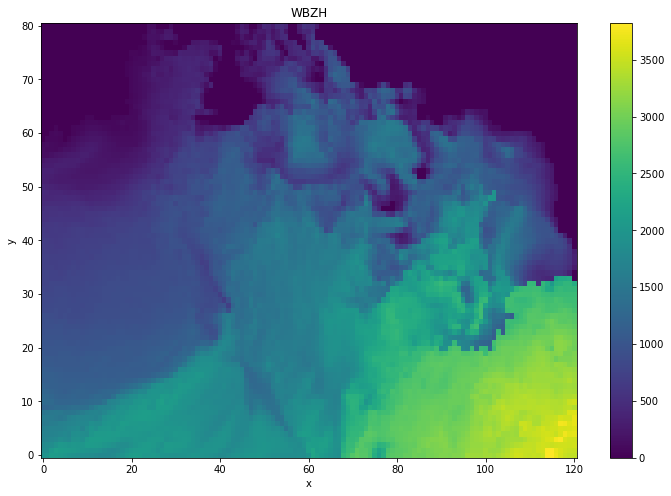

In [7]:
wbzh = calc_wbzh(data['tw'], data['gh'], data['orog'])

fig, ax = plt.subplots(1, figsize=(12, 8), facecolor='w')
wbzh.isel(time=i).plot(ax=ax)
ax.set_title('WBZH')
plt.show()

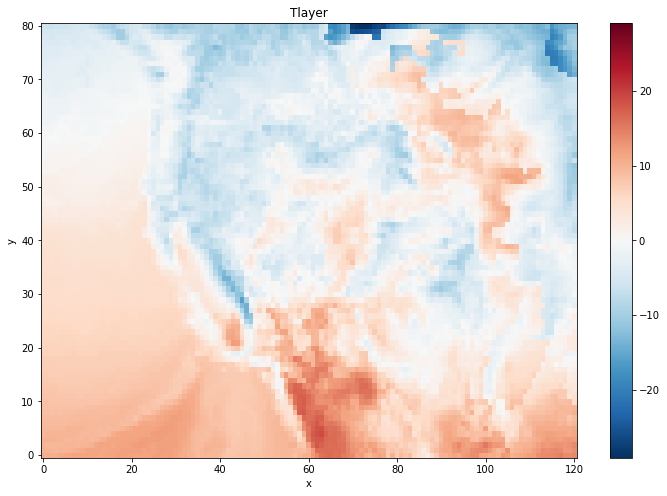

In [8]:
tlayer = calc_tlayer(data['t'], data['gh'], data['orog'])

fig, ax = plt.subplots(1, figsize=(12, 8), facecolor='w')
tlayer.isel(time=i).plot(ax=ax)
ax.set_title('Tlayer')
plt.show()

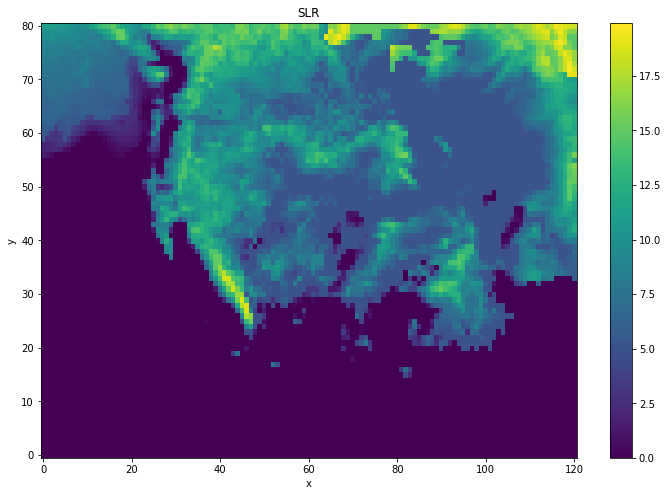

In [9]:
slr = calc_slr(tlayer, wbzh, data['orog'])

fig, ax = plt.subplots(1, figsize=(12, 8), facecolor='w')
slr.isel(time=i).plot(ax=ax)
ax.set_title('SLR')
plt.show()

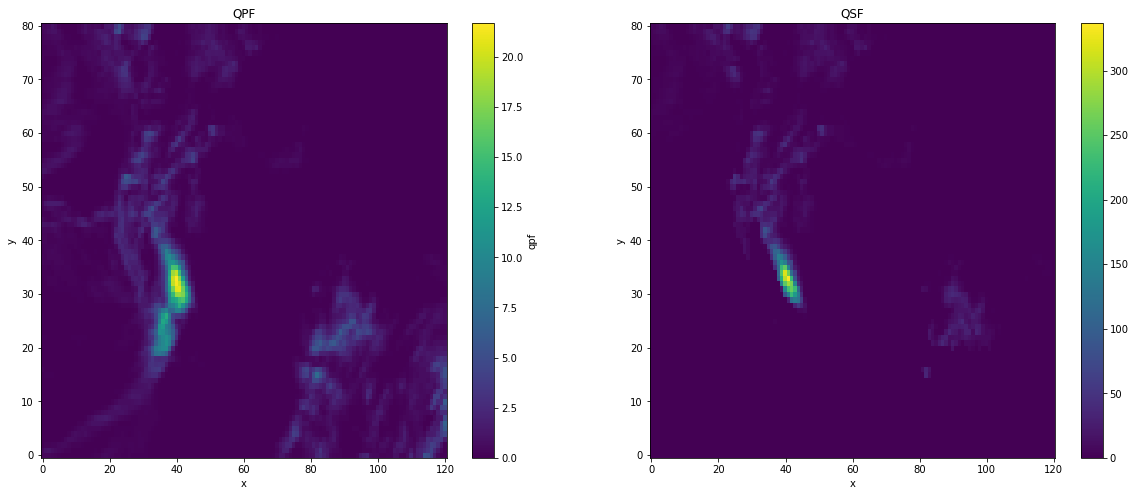

In [10]:
# Quantitative Snowfall Forecast (QPF * SLR)
qsf = data['qpf'] * slr

fig, ax = plt.subplots(1, 2, figsize=(20, 8), facecolor='w')
data['qpf'].isel(time=i).plot(ax=ax[0])
qsf.isel(time=i).plot(ax=ax[1])
ax[0].set_title('QPF')
ax[1].set_title('QSF')
plt.show()

In [50]:
site, interval, delay = 'CLNX', 12, 12
site_lat, site_lon = 40.5763, -111.6383

gfs_lat, gfs_lon = data['lat'], data['lon']

idx1d = (np.abs(gfs_lon - site_lon) + np.abs(gfs_lat - site_lat))
idx1d = np.where(idx1d == np.min(idx1d))

data['wbzh'] = wbzh
_data = data.isel(time=4, x=idx1d[1], y=idx1d[0])
_data

<xarray.Dataset>
Dimensions:  (level: 13, x: 1, y: 1)
Coordinates:
  * level    (level) int64 1000 975 950 925 900 850 800 750 700 650 600 550 500
    time     datetime64[ns] 2020-01-15T12:00:00
    lon      (y, x) float64 -111.8
    lat      (y, x) float64 40.5
Dimensions without coordinates: x, y
Data variables:
    t        (level, y, x) float32 4.808441 3.4605713 ... -21.747986 -24.9516
    tw       (level, y, x) float64 1.097 -0.09487 -1.289 ... -20.8 -23.04 -25.45
    gh       (level, y, x) float32 216.38503 422.11017 ... 4837.861 5534.8267
    qpf      (y, x) float64 0.0
    orog     (y, x) float32 2032.6997
    wbzh     (y, x) float64 319.4
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2020-08-13T08:35:43 GRIB to CDM+CF via cfgrib-0....

In [51]:
print('orog')
print(_data.orog.mean().values)

orog
2032.6997


In [52]:
print('gh')
for l, v in zip(_data.level.values[::-1], _data.gh.values[::-1]):
    print(l, v[0][0])

gh
500 5534.8267
550 4837.861
600 4193.3887
650 3593.777
700 3031.633
750 2500.206
800 1995.9392
850 1519.6547
900 1065.9427
925 846.66345
950 632.1422
975 422.11017
1000 216.38503


In [53]:
print('t')
for l, v in zip(_data.level.values[::-1], _data.t.values[::-1]):
    print(l, v[0][0])

t
500 -24.9516
550 -21.747986
600 -18.654388
650 -15.841858
700 -12.252106
750 -8.131378
800 -4.9965515
850 -3.6036682
900 -0.75006104
925 0.715271
950 2.115265
975 3.4605713
1000 4.808441


In [54]:
print('tw')
for l, v in zip(_data.level.values[::-1], _data.tw.values[::-1]):
    print(l, v[0][0])

tw
500 -25.45233044879052
550 -23.036571721175562
600 -20.796539061615306
650 -17.41473395430475
700 -13.647455139537044
750 -10.295054536683722
800 -7.741539452725874
850 -6.379889746924903
900 -3.8244719147957653
925 -2.5309860692392476
950 -1.288762327479958
975 -0.09486572807020366
1000 1.0971419951212056


In [62]:
print('wbzh')
print(_data.wbzh.values[0][0])

wbzh
319.44402389318464


In [76]:
print('tlayer')
tlayer.isel(time=4, x=idx1d[1], y=idx1d[0]).values[0][0]

tlayer


-9.066006

In [70]:
print('slr')
print(slr.isel(time=4, x=idx1d[1], y=idx1d[0]).values[0][0])

slr
14.06600570678711
